## **LIBRARY**

In [1]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import zipfile
import glob
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

### **DATA PRE-PROCESSING**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# You can get the dataset and preprocessed dataset on the drive link below,you can copy the folder to your own google drive.
# https://drive.google.com/drive/folders/113RBqGn2YrB5u7D7OT9X5y6uMLAfpvRI?usp=sharing

In [ ]:
basedir = '/content/drive/MyDrive/bangkit/dataset'

In [ ]:
local_zip = '/content/drive/MyDrive/bangkit/resumes_corpus.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(basedir)
zip_ref.close()

In [ ]:
y = []
filelist = glob.glob(os.path.join(basedir, '*.lab'))
for infile in sorted(filelist): 
  with open(infile) as f:              
    temp = f.readline()
    y.append(pd.Series(temp.rstrip('\n')))
y = np.array(y)
len(y)
pd.DataFrame(np.array(y)).to_csv("/content/drive/MyDrive/bangkit/lab.csv",index=None)

29783

In [ ]:
x = []
filelistx = glob.glob(os.path.join(basedir, '*.txt'))
for infile in sorted(filelistx): 
  with open(infile,encoding = "ISO-8859-1") as f:              
    temp = f.readline()
    x.append(pd.Series([temp.rstrip('\n')]))
x = np.array(x)
len(x)
pd.DataFrame(np.array(x)).to_csv("/content/drive/MyDrive/bangkit/corpus.csv",index=None)

29783

In [ ]:
lab = pd.read_csv('/content/drive/MyDrive/bangkit/lab.csv')
resume = pd.read_csv('/content/drive/MyDrive/bangkit/corpus.csv')
list_of_tuples = list(zip(lab['0'], resume['0'])) 
df = pd.DataFrame(list_of_tuples,
                  columns = ['Job', 'Resume']) 

In [ ]:
df.dropna(subset = ["Job"], inplace=True)
df.isnull().any() 
pd.DataFrame(df).to_csv("/content/drive/MyDrive/bangkit/df.csv",index=None)

Job       False
Resume    False
dtype: bool

## **Data Preview**

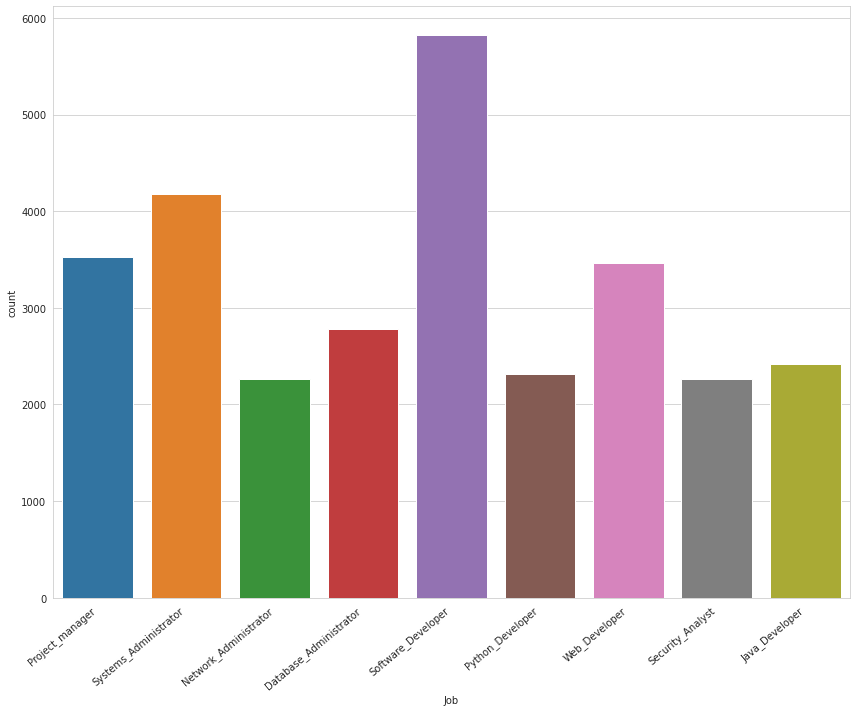

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 10))
ax = sns.countplot(x='Job', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [11]:
df.head()

,Job,Resume
0,Project_manager,Software Project Manager Software <span class=...
1,Systems_Administrator,System Operation Engineer System Operation Eng...
2,Project_manager,Sales Engineer Sales Engineer Project Manager/...
3,Network_Administrator,"Network Engineer <span class=""hl"">Network</spa..."
4,Systems_Administrator,SYSTEMS ENGINEER SYSTEMS ENGINEER SYSTEMS ENGI...


# **Baseline CNN-LSTM Model**

In [ ]:
#Make the shuffled version of the dataset that will be used for model training
newdf = df.sample(frac=1).reset_index(drop=True)
pd.DataFrame(newdf).to_csv("/content/drive/MyDrive/bangkit/newdf.csv",index=None)

In [12]:
vocab_size = 10000
embedding_dim = 64
max_length = 300
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
test_portion = .2

In [14]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ,"span", "class", "hl"]

In [15]:
def clean_text(sentence):
    for word in stopwords:
      token = " " + word + " "
      sentence = str(sentence).replace(token, " ")
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [16]:
with open("/content/drive/MyDrive/bangkit/newdf.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
      if any(c.isalpha() for c in row[0])==True and any(c.isalpha() for c in row[1])==True:
        labels.append(row[0])
        sen = row[1]
        sentence = clean_text(sen)
        sentences.append(sentence)
      else:
        pass

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * len(sentences))

test_sequences = padded[0:split]
training_sequences = padded[split:]
test_labels = labels[0:split]
training_labels = labels[split:]

In [18]:
label_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(training_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(test_labels))

In [40]:
label_index = label_tokenizer.word_index
list(label_index.items())

[('software_developer', 1),
 ('systems_administrator', 2),
 ('project_manager', 3),
 ('web_developer', 4),
 ('database_administrator', 5),
 ('java_developer', 6),
 ('python_developer', 7),
 ('network_administrator', 8),
 ('security_analyst', 9)]

In [20]:
#training_labels
training_label_seq
#training_sequences

array([[4],
       [4],
       [8],
       ...,
       [6],
       [5],
       [5]])

In [21]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 10000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
#    tf.keras.layers.Conv1D(128, 5, activation='relu'),
#    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu', kernel_regularizer=(tf.keras.regularizers.L2(0.001))),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 64)           9284480   
_________________________________________________________________
dropout (Dropout)            (None, 300, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 32)           10272     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 74, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 70, 64)            10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 17, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 64)            0

In [22]:
num_epochs = 12

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(training_sequences, training_label_seq, epochs=num_epochs, validation_data=(test_sequences, validation_label_seq), verbose=2, callbacks=[model_checkpoint_callback])

model.load_weights(checkpoint_path)

Epoch 1/12
726/726 - 100s - loss: 1.1033 - accuracy: 0.6055 - val_loss: 0.5908 - val_accuracy: 0.8204
Epoch 2/12
726/726 - 64s - loss: 0.5190 - accuracy: 0.8446 - val_loss: 0.4562 - val_accuracy: 0.8667
Epoch 3/12
726/726 - 64s - loss: 0.3614 - accuracy: 0.8936 - val_loss: 0.4115 - val_accuracy: 0.8786
Epoch 4/12
726/726 - 64s - loss: 0.2486 - accuracy: 0.9294 - val_loss: 0.4225 - val_accuracy: 0.8838
Epoch 5/12
726/726 - 64s - loss: 0.1737 - accuracy: 0.9531 - val_loss: 0.4570 - val_accuracy: 0.8869
Epoch 6/12
726/726 - 64s - loss: 0.1260 - accuracy: 0.9662 - val_loss: 0.4964 - val_accuracy: 0.8800
Epoch 7/12
726/726 - 64s - loss: 0.0928 - accuracy: 0.9775 - val_loss: 0.4911 - val_accuracy: 0.8846
Epoch 8/12
726/726 - 64s - loss: 0.0804 - accuracy: 0.9799 - val_loss: 0.5132 - val_accuracy: 0.8817
Epoch 9/12
726/726 - 64s - loss: 0.0696 - accuracy: 0.9822 - val_loss: 0.5155 - val_accuracy: 0.8774
Epoch 10/12
726/726 - 64s - loss: 0.0612 - accuracy: 0.9850 - val_loss: 0.5742 - val_accur

In [ ]:
model.save('/content/drive/MyDrive/bangkit/baseline_model.h5')
#model = tf.keras.models.load_model('/content/drive/MyDrive/bangkit/baseline_model.h5')

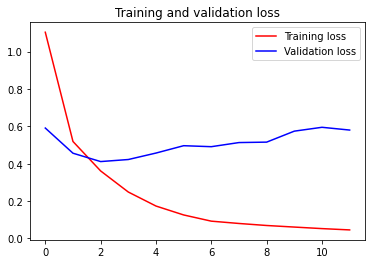

<Figure size 432x288 with 0 Axes>

In [24]:
#with regularization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

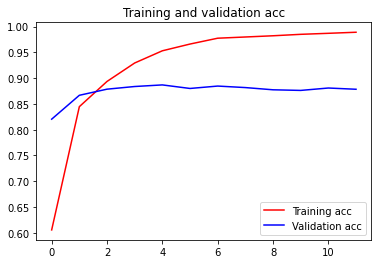

<Figure size 432x288 with 0 Axes>

In [25]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend(loc=0)
plt.figure()
plt.show()

# Try use the model to predict a string containing extracted resume informations

In [54]:
labs = [list(label_index.keys())]
inputs = "Family Private Care LLC Lawrenceville, GA A self-motivated Production SQL Server Database Administrator who possesses  strong analytical and problem solving skills. My experience includes SQL Server  2005, 2008 and 2012, 2014, SSIS, as well as clustering, mirroring, and high  availability solutions in OLTP environments. I am proficient in database backup,  recovery, performance tuning, maintenance tasks, security, and consolidation.  I am confident that I would make a beneficial addition to any company. Over the  course of my career thus far, I have designed databases to fit a variety of needs,  successfully ensured the security of those databases, problem-solved in order to meet  both back-end and front-end needs, installed and tested new versions database  management systems, customized and installed applications and meticulously  monitored performance for the smoothest front-end experience possible. During my  5 to 6 years working with databases. Work Experience Database Administrator Family Private Care LLC - Roswell, GA April 2017 to Present Confirm that backups have been made and successfully saved to a secure  location  Planning for backup and recovery of database information.  Maintaining archived data Backing up and restoring databases, Contacting  database vendor for technical support Generating various reports by querying from database as per needed.  Managing and monitoring data replication. Acting as liaison with users High  Availability or Disaster Recovery Logs - Check your high availability and/or disaster recovery process logs. Depending on the solution (Log Shipping,  Clustering, Replication, Database Mirroring, CDP, etc.) that you are using  dictates what needs to be checked. Correcting errors and make necessary  modification  Modify existing databases and database management systems or direct  programmers and analysts to make changes.  Work as part of a project team to coordinate database development and see  termite project scope and limitations  Train Users and answers questions.  Approve, schedule, plan, and supervise the installation and testing of new  products and improvements to computer systems, such as the installation of new databases.  Review Procedures in Database management system manuals for making  changes to database.  Select and enter codes to monitor database performance and to create  production database.  Check the backup failure alerts, correct the errors and rerun the backups.  Review the average duration of backup, any significant changes occurred  investigates on this.  Most of the time it happens due to networking low bandwidth Validate the backup files using restore verify only.  I create jobs to take care of the task and to send a notification if it fails to verify  any backup.  Monitoring all backup and log history is cleaning when designed. Find out the newly added databases and define the backup plan. I do verify the free space on  each drive on all servers, If there is significant variance in free space from the day before, research the cause of the free space fluctuation and resolve if  necessary, Often times, log files will grow because of monthly jobs automate through a job. The job runs for every one hour and reports any drive which is  having less than 15 % of free space.  I can design a SSRS report to showcase and review the delta values.  Confirm all servers/databases are up and running fine. Usually in an Enterprise  Database Environment Third Party Tools are used to monitor Servers. For  database monitoring, I can design a native SQL Server solution using T-SQL  code and a maintenance plan, it run min by min and send an email to DBA  team if it is not able to connect to any of the database in the instance. I do design a native scripts using T-SQL to monitor Replication, Mirroring, Log  shipping. Database Administrator Incomm Alpharetta - Alpharetta, GA January 2014 to February 2017 * Responsible for administering and maintaining over 150 database servers of Production and Test environment.  * Analyzes the current database environment to determine recommended database  maintenance, security, and Microsoft SQL Server best practices.  * Monitors and troubleshoots production environments using Idera SQLdm.  * Creates and maintains documentation for DBA standard operating procedures.  * Ensures that all code changes made in the production environment are SOX  compliance before they are deployed.  * Analyses and migrates data using ETL into SQL Server databases to support  customer's implementation.  * Works closely with infrastructure team for patching and hardware upgrades, and ensures that both production and test servers are up to date by applying Windows  and SQL Server patches.  * Upgrades servers as required from SQL Server 2005 to SQL Server 2008, 2012., and 2014.  * Completes database administration maintenance projects as required * Provides  24/7 on call support as needed.  * Coordinates and configures new nodes for production server clusters for high  availability.  * Periodically restores backup files in test environment to check for corruption.  * Reviews security, performance, and disk space and recommend corrective actions  where needed.  * Assists application team in the creation of databases, construction of queries, modification of database tables, and troubleshooting data issues.  * Monitors servers for resources utilization (disk space, memory, CPU, etc.)  * Creates and Executes a migration/decommission plan for over 500 databases within a 4 month project window. Education Bachelor of Science Lead City University July 2013 Skills Database administration, Database, Ms sql server, Ms sql server 2005, Sql server, Sql server 2005, Sql server 2008, Sql server 2008 r2, Sql server 2012, Sql, Sql queries, Stored procedures, Clustering, Backups, T-sql, Virtualization, R2, Maintenance, Problem solving, Shipping Additional Information SKILLS  Installation and Building Server Running Backups Recovering and  Restoring Models  Support various MS SQL Server MS SQL Server 2005/2008  environments from SQL Server /2008R2R2/2012/2014  2005 thru SQL Server 2008r2 as administration including  well as with SQL Server 2012 on installation, configuration,  Windows Server 2003, 2003r2, upgrades, capacity planning,  2008, 2008r2, 2012 and 2014. performance tuning, backup and  recovery.  Familiar with virtualization and Work with developers to Identify,  managing SQL databases in a debug, and tune problem stored  virtual environment. procedures, T-SQL Queries, etc.  Management of users including Knowledge of High Availability of  creation/alteration, grant of database servers using Database  system/DB roles and permissions mirroring, replications, Log  on various database objects. Shipping and Always On  Availability Group.  Design and implement SQL Server 201, databases for mission-critical  2005, SQL Server 2008 R2, business.  Experience in creating tables, Environment transition planning  views, indexes, stored procedures (development, test, stage,  and more. production).  Import and export data to and from Perform routine backup and  the database servers. recovery testing and documenting  recovery scenarios.  Database administration including Use SQL Profiler for  installation, configuration, troubleshooting, monitoring, and  upgrades, capacity planning, optimization of SQL Server and  performance tuning, backup and SQL code.  recovery, index maintenance.  Modify stored procedures, queries, Manage the production and  views, indexes, and functions to development databases including  handle business rules, history data performance tuning, capacity  and audit analysis. planning, SQL Server clustering,  database security configuration,  and database continuity.  Excellent analytical, Strong decision making and  communication skills, work ethics problem solving skills.  and ability to work in a team  environment with strong  determination and commitment to  the deliverables.  Highly motivated self-starter with  the ability to work independently."
clean_inputs = [clean_text(inputs)]
print(str(clean_inputs)+'\n')
seq = tokenizer.texts_to_sequences(clean_inputs)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(str(padded)+'\n')
proba = model.predict(padded)[0,1:]
#print only max value
max = np.where(proba == np.amax(proba))
for [i] in max:
  idx = i
predlabel = labs[0][idx]
predprob = proba[idx]*100
print(list(map("This resume is fit to {} jobs with probability of {:.2f}%".format,[predlabel],[predprob])))


for (label, p) in zip(labs, [proba[::-1]]):
  print("Probability for each classes are : " + str(list(map("{}: {:.2f}%".format,label,p*100))))

['Family Private Care LLC Lawrenceville GA self motivated Production SQL Server Database Administrator possesses strong analytical problem solving skills My experience includes SQL Server SSIS well clustering mirroring high availability solutions OLTP environments proficient database backup recovery performance tuning maintenance tasks security consolidation confident make beneficial addition company Over the course career thus far designed databases fit variety needs successfully ensured security databases problem solved order meet back end front end needs installed tested new versions database management systems customized installed applications meticulously monitored performance smoothest front end experience possible During my years working databases Work Experience Database Administrator Family Private Care LLC Roswell GA April Present Confirm backups made successfully saved secure location Planning backup recovery database information Maintaining archived data Backing restoring d